In [22]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import re
import warnings
warnings.filterwarnings("ignore")

print("Libraries loaded.")

Libraries loaded.


In [23]:
# Step 2: Read and Parse the Raw File

# Read entire file
with open('dengue_data_with_weather_data.csv', 'r') as file:
    content = file.read().strip()

# Use regex to find all valid rows starting with 2019, 2020, or 2021
# Each row has 11 comma-separated values
pattern = r'(2019|2020|2021),([^,]+),([^,]+),([^,]+),([^,]+),([^,]+),([^,]+),([^,]+),([^,]+),([^,]+),([^,\n]+)'
matches = re.findall(pattern, content)

print(f"Found {len(matches)} valid rows.")

# Convert to DataFrame
columns = [
    'year', 'province', 'district', 'latitude', 'longitude',
    'district_no', 'month', 'dengue_cases',
    'temperature', 'rainfall', 'humidity'
]

df = pd.DataFrame(matches, columns=columns)

# Convert data types
df['year'] = pd.to_numeric(df['year'])
df['month'] = pd.to_numeric(df['month'])
df['dengue_cases'] = pd.to_numeric(df['dengue_cases'])
df['temperature'] = pd.to_numeric(df['temperature'])
df['rainfall'] = pd.to_numeric(df['rainfall'])
df['humidity'] = pd.to_numeric(df['humidity'])
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])
df['district_no'] = pd.to_numeric(df['district_no'])

print("Data cleaned and typed.")
df.head()

Found 899 valid rows.
Data cleaned and typed.


,year,province,district,latitude,longitude,district_no,month,dengue_cases,temperature,rainfall,humidity
0,2019,Western,Colombo,6.924429,79.90725,4,1,1225,26.914286,0.771429,72.607143
1,2019,Western,Gampaha,7.065026,79.96622,19,1,724,27.417857,0.728571,69.892857
2,2019,Western,Kalutara,6.572935,80.02519,5,1,372,26.112500,1.396429,80.464286
3,2019,Central,Kandy,7.275923,80.62659,499,1,288,22.067857,1.853571,83.428571
4,2019,Central,Matale,7.486819,80.52632,362,1,62,25.592857,0.850000,74.285714


In [24]:
# Step 3: Create Proper Date Index (Monthly)

# Create date from year and month, set to first day of month
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

print("Date index created.")
print(f"Date range: {df.index.min()} to {df.index.max()}")

Date index created.
Date range: 2019-01-01 00:00:00 to 2021-12-01 00:00:00


In [25]:
# Step 4: Feature Engineering – Add Lagged Weather (Per District)

# Sort by district and time
df = df.sort_values(['district', 'date'])

# Define lag periods (1–3 months)
lag_periods = [1, 2, 3]

for lag in lag_periods:
    df[f'temp_lag{lag}'] = df.groupby('district')['temperature'].shift(lag)
    df[f'rain_lag{lag}'] = df.groupby('district')['rainfall'].shift(lag)
    df[f'humid_lag{lag}'] = df.groupby('district')['humidity'].shift(lag)

# Add seasonal features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

print("Lagged and seasonal features added.")

Lagged and seasonal features added.


In [26]:
# Step 5: Prepare Features and Target

feature_cols = [
    'temp_lag1', 'temp_lag2', 'temp_lag3',
    'rain_lag1', 'rain_lag2', 'rain_lag3',
    'humid_lag1', 'humid_lag2', 'humid_lag3',
    'month_sin', 'month_cos',
    'latitude', 'longitude'
]

# Drop rows with NaN from lagging
df_clean = df[feature_cols + ['dengue_cases']].dropna()

X = df_clean[feature_cols]
y = df_clean['dengue_cases']

print(f"Final dataset shape: {X.shape}")

Final dataset shape: (824, 13)


In [27]:
# Step 6: Time-Based Train/Test Split

# Use everything before 2021-01-01 for training
split_date = '2021-01-01'

X_train = X[X.index < split_date]
X_test = X[X.index >= split_date]
y_train = y[y.index < split_date]
y_test = y[y.index >= split_date]

print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test period: {X_test.index.min()} to {X_test.index.max()}")
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

Training period: 2019-04-01 00:00:00 to 2020-12-01 00:00:00
Test period: 2021-01-01 00:00:00 to 2021-12-01 00:00:00
Train size: 524, Test size: 300


In [28]:
# Step 7: Train XGBoost Model

model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Model trained.")

Model trained.


In [29]:
# Step 8: Evaluate Model

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("=== Model Performance ===")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

=== Model Performance ===
MAE:  258.89
RMSE: 425.37
R²:   -1.27


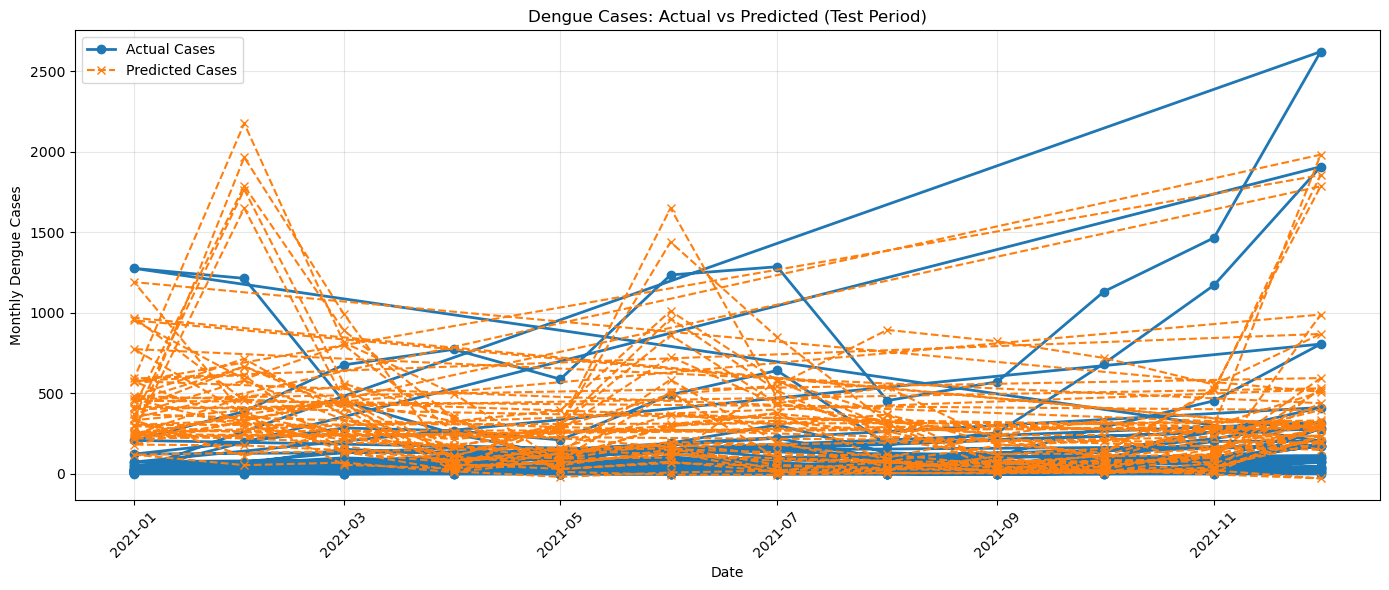

In [30]:
# Step 9: Plot Actual vs Predicted

plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Actual Cases', marker='o', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Cases', marker='x', linestyle='--')
plt.title('Dengue Cases: Actual vs Predicted (Test Period)')
plt.xlabel('Date')
plt.ylabel('Monthly Dengue Cases')
plt.legend()
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

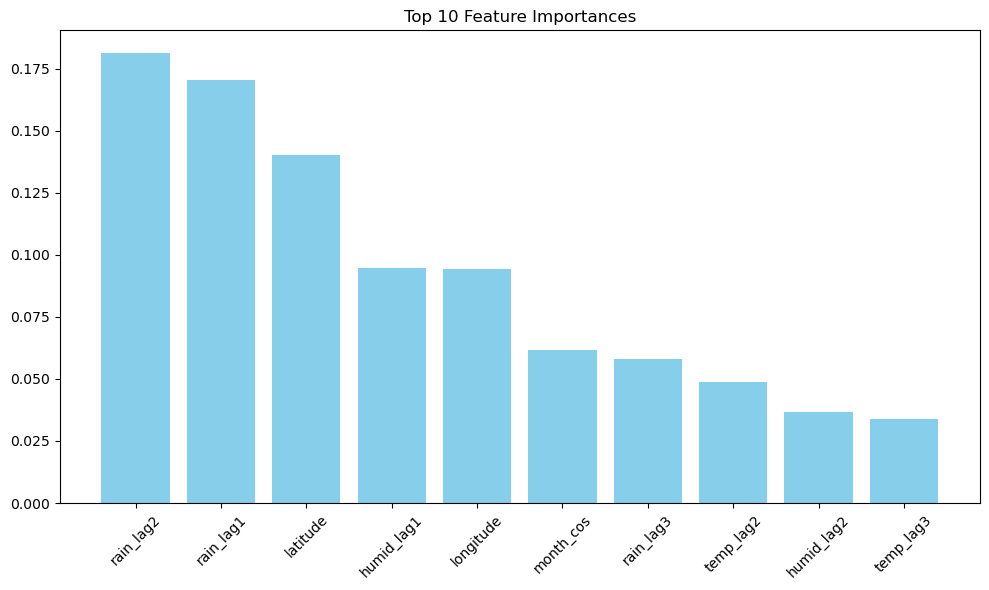

In [31]:
# Step 10: Feature Importance

importances = model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices], color='skyblue')
plt.xticks(range(10), [feat_names[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

In [32]:
import joblib

# Save the trained XGBoost model
joblib.dump(model, 'model.pkl')

# Save the label encoder for 'district' (if used), or one-hot encoder
from sklearn.preprocessing import LabelEncoder

# If you used LabelEncoder on district
le_district = LabelEncoder()
le_district.fit(df['district'])  # fit on all districts
joblib.dump(le_district, 'encoder.pkl')

print("Model and encoder saved!")

Model and encoder saved!


In [33]:
# Step 12: Create District Coordinates and Province Mapping

# Calculate average coordinates for each district
district_coords = df.groupby('district')[['latitude', 'longitude']].mean().round(6)
print("District average coordinates:")
print(district_coords)

# Create province-district mapping based on the data
province_district_mapping = df.groupby('province')['district'].unique().apply(list).to_dict()
print("\nProvince-District mapping:")
for province, districts in province_district_mapping.items():
    print(f"{province}: {districts}")

# Save district coordinates as a dictionary for use in the API
district_coords_dict = district_coords.to_dict('index')
print(f"\nDistrict coordinates dictionary saved with {len(district_coords_dict)} districts")

# Also save the mapping for the frontend
import json
with open('district_coords.json', 'w') as f:
    json.dump(district_coords_dict, f, indent=2)

with open('province_district_mapping.json', 'w') as f:
    json.dump(province_district_mapping, f, indent=2)
    
print("Files saved: district_coords.json and province_district_mapping.json")

District average coordinates:
              latitude  longitude
district                         
Ampara        7.275923  81.693474
Anuradhapura  8.330404  80.428820
Badulla       6.994728  81.037970
Batticaloa    7.697715  81.651060
Colombo       6.924429  79.907250
Galle         6.080843  80.233730
Gampaha       7.065026  79.966220
Hambantota    5.940246  80.550000
Jaffna        9.666080  80.034874
Kalutara      6.572935  80.025190
Kandy         7.275923  80.626590
Kegalle       7.275923  80.321760
Kilinochchi   9.384886  80.382280
Kurunegala    7.486819  80.373520
Mannar        8.963093  79.965430
Matale        7.486819  80.526320
Matara        6.151143  81.127815
Moneragala    6.854130  81.356360
Mulativu      9.244288  80.789246
Nuwara Eliya  6.994728  80.734180
Polonnaruwa   7.908612  81.015360
Puttalam      8.049210  79.846150
Ratnapura     6.713532  80.386880
Trincomalee   8.611599  81.170395
Vavuniya      8.752197  80.534480

Province-District mapping:
Central: ['Kandy', 'Mata